In [11]:
import os
import time
import shutil
import pathlib
import itertools
import random
# import data handling tools
import tensorflow as tf


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.image as mpimg                           # Image loading and manipulation library
from tensorflow.keras.models import Sequential, Model      # Sequential and Functional API for building models
from tensorflow.keras.optimizers import Adam              # Adam optimizer for model training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau ,LambdaCallback      # Early stopping callback for model training
from tensorflow.keras.regularizers import l1, l2           # L1 and L2 regularization for model regularization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for images
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization        # Various types of layers for building neural networks
from tensorflow.keras.applications import  EfficientNetB0, InceptionV3, Xception, ResNet50, VGG16
from sklearn.utils.class_weight import compute_class_weight


In [3]:
image_size = 256
batch_size = 32
channels = 3

In [5]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset/training/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

train_data = train_data.map(lambda x, y: (x / 255.0, y))


val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset/training/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

val_data = val_data.map(lambda x, y: (x / 255.0, y))


test_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/dataset/training/test',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

test_data = test_data.map(lambda x, y: (x / 255.0, y))

Found 14013 files belonging to 10 classes.
Found 3000 files belonging to 10 classes.
Found 2999 files belonging to 10 classes.


In [6]:
class_names = ['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']


In [7]:
# Load the ResNet50 model with pre-trained ImageNet weights, without the top layer
base_model5 = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Fine-tune some top layers of the base model
for layer in base_model5.layers[-20:]:  # Unfreeze the last 20 layers for fine-tuning
    layer.trainable = True

# Add custom layers on top of the base model
x5 = base_model5.output
x5 = GlobalAveragePooling2D()(x5)
x5 = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x5)  # L2 regularization
x5 = Dropout(0.5)(x5)  # Dropout for regularization

# Determine the number of classes from the original training dataset
num_classes5 = len(next(os.walk('/content/drive/MyDrive/dataset/training/train'))[1])
predictions5 = Dense(num_classes5, activation='softmax')(x5)

# Define the model
ResNet50_model = Model(inputs=base_model5.input, outputs=predictions5)

# Compile the model with a lower learning rate
ResNet50_model.compile(optimizer=Adam(learning_rate=1e-5),  # Reduced learning rate
              loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks with increased patience and learning rate scheduling
callbacks5 = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('resnet50_final_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7),  # Reduce learning rate on plateau
    LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1}: Accuracy: {logs['accuracy']:.4f}, Validation Accuracy: {logs['val_accuracy']:.4f}"))
]



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Train the ResNet50 model
history5 = ResNet50_model.fit(
    train_data,
    epochs=25,  # Number of epochs
    validation_data=val_data,
    callbacks=callbacks5
)

# Save the final model in both .keras and .h5 formats
ResNet50_model.save('/content/drive/MyDrive/Res_50_model.keras')
ResNet50_model.save('/content/drive/MyDrive/Res_50_model.h5')

print("ResNet50 model has been trained and saved.")

import pickle

# Save training history
with open('/content/drive/MyDrive/Res_50_model_history.pkl', 'wb') as file_pi:
    pickle.dump(history2.history, file_pi)


print("Training history for ResNet50 model has been saved.")


Epoch 1/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4559 - loss: 2.9898Epoch 1: Accuracy: 0.6684, Validation Accuracy: 0.1077
438/438 ━━━━━━━━━━━━━━━━━━━━ 5248s 12s/step - accuracy: 0.4564 - loss: 2.9884 - val_accuracy: 0.1077 - val_loss: 6.5208 - learning_rate: 1.0000e-05
Epoch 2/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9193 - loss: 1.6220Epoch 2: Accuracy: 0.9353, Validation Accuracy: 0.1887
438/438 ━━━━━━━━━━━━━━━━━━━━ 161s 366ms/step - accuracy: 0.9194 - loss: 1.6219 - val_accuracy: 0.1887 - val_loss: 5.3804 - learning_rate: 1.0000e-05
Epoch 3/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9658 - loss: 1.4492Epoch 3: Accuracy: 0.9743, Validation Accuracy: 0.9757
438/438 ━━━━━━━━━━━━━━━━━━━━ 160s 365ms/step - accuracy: 0.9658 - loss: 1.4491 - val_accuracy: 0.9757 - val_loss: 1.3884 - learning_rate: 1.0000e-05
Epoch 4/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9849 - loss: 1.3738Epoch 4: Accuracy: 0.9869, Validation Accur

ResNet50 model has been trained and saved.


NameError: name 'history2' is not defined

In [ ]:
# Evaluate the ResNet50 model on the test set
ResNet50_test_loss, ResNet50_test_accuracy = ResNet50_model.evaluate(test_data)
print(f"ResNet50 Test Accuracy: {ResNet50_test_accuracy * 100:.2f}%")


94/94 ━━━━━━━━━━━━━━━━━━━━ 849s 9s/step - accuracy: 0.9902 - loss: 0.4319
ResNet50 Test Accuracy: 99.20%


Found 2999 images belonging to 10 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━

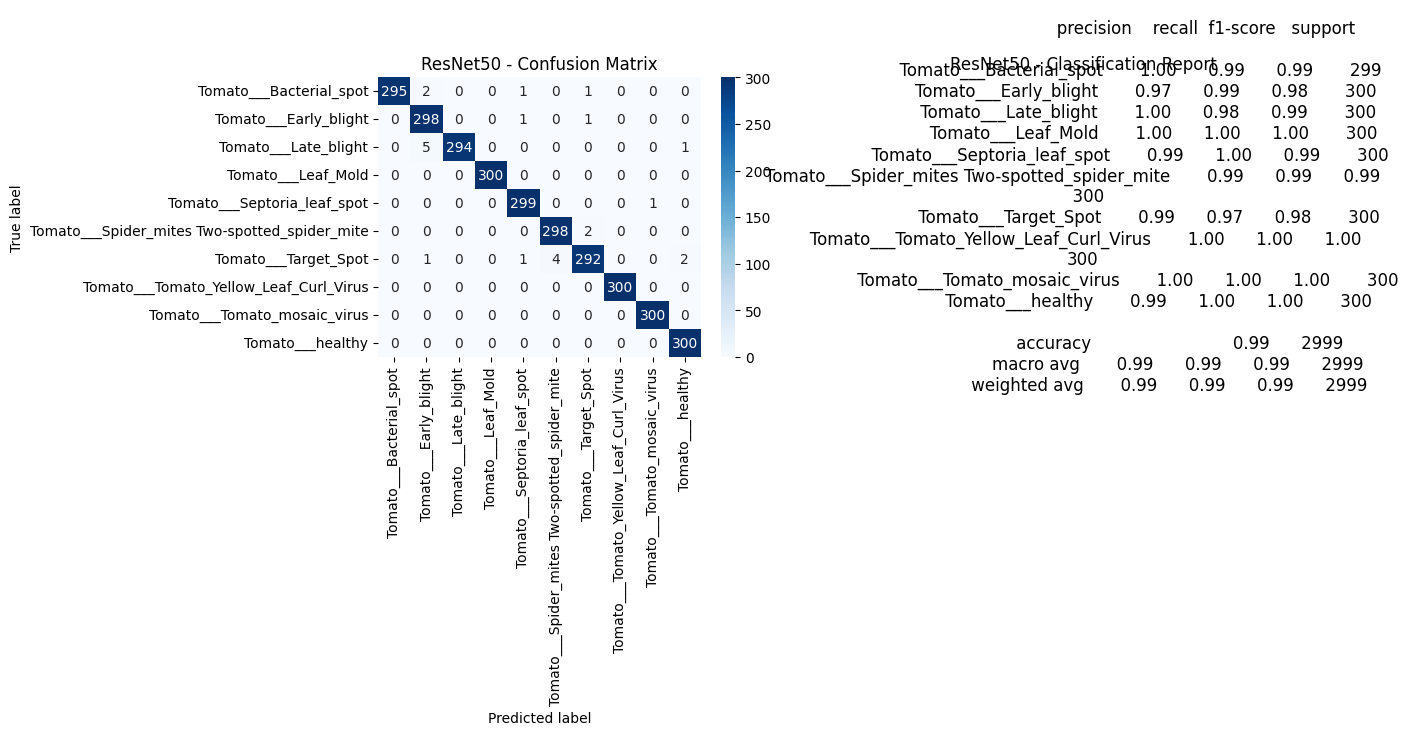

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Function to plot confusion matrix and classification report
def plot_confusion_matrix_and_report(cm, report, classes, title, color_palette):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap=color_palette, xticklabels=classes, yticklabels=classes, ax=ax1)
    ax1.set_title(f'{title} - Confusion Matrix')
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')

    # Plot classification report
    ax2.text(0.5, 0.5, report, ha='center', va='center', fontsize=12, wrap=True)
    ax2.set_title(f'{title} - Classification Report')
    ax2.axis('off')  # Hide the axes for the report

    plt.tight_layout()
    plt.show()

# Define the path to your test data
test_data_dir = '/content/drive/MyDrive/dataset/training/test'
# Create an ImageDataGenerator for test data with rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and iterate over the test data using flow_from_directory
test_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important to keep data in order for accurate evaluation
)

# Define your class names
class_names =['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']
  # Replace with your actual class names if different

# Load the EfficientNetB0 model
EfficientNetb0_model_h5 = load_model('/content/drive/MyDrive/Res_50_model.h5')

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Evaluate the model on the test data and generate predictions
for images, labels in test_data:
    # Predict the labels
    predictions = EfficientNetb0_model_h5.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Get the true labels
    true_labels = np.argmax(labels, axis=1)

    y_true.extend(true_labels)
    y_pred.extend(predicted_labels)

    # Break the loop once all test data has been processed
    if len(y_true) >= test_data.samples:
        break

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix for ResNet50 model
cm = confusion_matrix(y_true, y_pred)

# Generate classification report for ResNet50 model
report = classification_report(y_true, y_pred, target_names=class_names)

# Plot confusion matrix and classification report
plot_confusion_matrix_and_report(cm, report, classes=class_names, title='ResNet50', color_palette='Blues')


In [8]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/Res_50_model.keras')

In [10]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

# Print the test accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 508s 5s/step - accuracy: 0.9923 - loss: 0.4162
Test Accuracy: 0.9920


In [14]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Extract true labels from the dataset
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())

# Predict classes for test data
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

# Convert y_true to a numpy array
y_true = np.array(y_true)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=test_data.class_names))



94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
from keras.models import load_model

# Load the model architecture and weights from the .h5 file
model = load_model('/content/drive/MyDrive/Res_50_model.h5')

# You can use the model to make predictions, evaluate, or continue training
# Example of using the model for prediction or evaluation:
# predictions = model.predict(x_test)
# model.evaluate(x_test, y_test)
